### Define utils

In [11]:
import numpy as np
import netCDF4 as nc
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import pandas as pd
from cmcrameri import cm
import matplotlib.transforms as transforms

In [12]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands

from utils.ppr import *

In [13]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

%matplotlib widget

In [14]:
# outname = "mnras_proteus_agni/hd63433d_v6"
outname = "mnras_proteus_agni/ltt3780b_v5"
stride = 2

In [15]:
globber = os.path.join(os.environ.get("HOME"),"analysis/data/article_data",outname) + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
for folder in cases:
    conf.append( read_config(folder+"init_coupler.toml") )
    post.append( read_postproc(folder) )
print("Done")

/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/ltt3780b_v5/case_*/
npoints = 22
Done


In [16]:
indep_var = "fO2_shift_IW"
indep_lbl = r"log$_{10}$ (fO$_{2}$ / IW)"

indep_vals = set()
for i in range(npoints):
    indep_vals.add(conf[i][indep_var])

indep_max = np.amax(np.abs(list(indep_vals)))

In [17]:
cmap = cm.roma
norm = mpl.colors.Normalize(vmin=-indep_max, vmax=indep_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

def add_cbar(fig):
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.86, 0.15, 0.04, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax, values=sorted(indep_vals))
    cbar.set_label(indep_lbl)

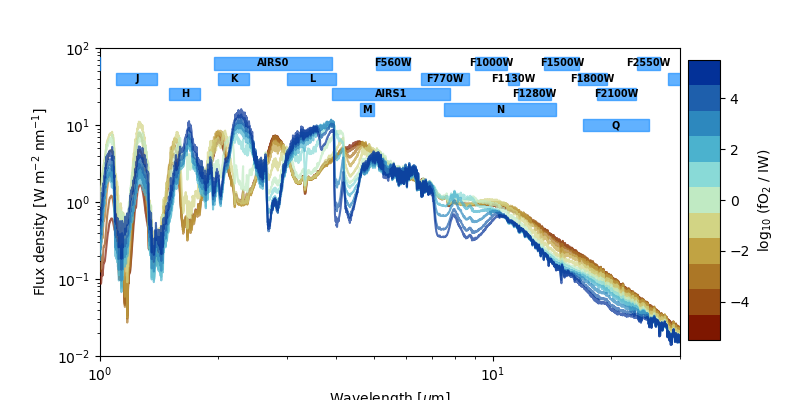

mnras_proteus_agni/ltt3780b_v5


In [18]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(8,4))

instruments = ["MIRI", "ARIEL", "IR"]
ylim = [1e-2, 1e2]
xlim = [1, 30.0]
time_idx = -1
logy = True
logx = True
al=0.7

# plot emission spectra
for i in range(npoints):
    if conf[i]["atmosphere_model"] == 0:
        continue

    dat = post[i]
    lbl = conf[i]["fO2_shift_IW"]
    col = sm.to_rgba(float(lbl))
    ls = 'solid'

    x = (dat["bandmax"] + dat["bandmin"]) * 0.5 * 1e6
    w = np.abs(dat["bandmax"] - dat["bandmin"]) * 1e9

    y = (dat["ba_U_SW"][time_idx] + dat["ba_U_LW"][time_idx]) / w
    # y = dat["ba_U_SW"][time_idx] / dat["ba_D_SW"][time_idx]

    ylim[1] = max(ylim[1], np.amax(y[2:]))
    ax.plot(x,y,label=lbl, linestyle=ls, c=col, zorder=i, alpha=al)

# plot instrument bandpasses
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
i = -1
prev_bands = []
for ins in instruments:
    bands = observer_bands[ins]

    for b in bands:
        i += 1
        v = bands[b]

        h = 0.04
        s = 0.05
        yt = 0.95
        xeps = 1.2

        if i == 0:
            y0 = yt
        else:
            for j in range(30):
                # try this y-location
                ok = True
                y0 = yt - j * s

                # check there's no overlap with other bands
                for p in prev_bands:
                    if np.isclose(p[2],y0):
                        if (p[0]< v[1] < p[1]) or (p[0] < v[0] < p[1]):
                            ok = False
                            break
                if ok:
                    break
        prev_bands.append([v[0]/xeps,v[1]*xeps,y0])
        x0 = np.sqrt(v[0]*v[1])

        prev_bands.append([v[0],v[1],y0])
        ax.add_patch(mpatches.Rectangle( (v[0], y0-h/2), width=v[1]-v[0], height=h,
                                        transform=trans,
                                        alpha=0.7, zorder=98, color='dodgerblue'))
        ax.text(x0, y0 , b, fontsize=7, color='k', weight='bold',
                clip_on=True, zorder=99, transform=trans,
                rotation=-0, horizontalalignment='center', verticalalignment='center')

# decorate plot
add_cbar(fig)
ax.set_ylim(ylim)
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax.set_xlim(xlim)
if logx:
    ax.set_xscale("log")
if logy:
    ax.set_yscale("log")
ax.set_ylabel(r"Flux density [W m$^{-2}$ nm$^{-1}$]")

# plot and save
for fmt in ["png","pdf"]:
    fig.savefig("output/emission_ppr.%s"%fmt,bbox_inches='tight', dpi=300)
plt.show()
print(outname)